In [2]:
import os
import utils.cop as cop
from utils.data_loader import load_data, load_file, convert_signal
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

%matplotlib widget

In [11]:
def generate_mask(signal, threshold=5):
    print('Generating Mask...')
    freq = 0.05
    seconds = 3
    window = int(seconds / freq)
    active = False
    c = 100
    count = []

    for i, x in enumerate(signal):
        if i <= window:
            c += 1
            count.append(c)
            continue
        
        if x > threshold:
            active = True
            c = 0

        if active and c < window:
            c += 1
            count.append(c)
            continue 
        
        if c > window:
            active = not active

        c += 1    
        count.append(c)
        
    return np.array([True if x < window else False for x in count])

# All Recordings for the day

In [12]:
root_folder = './COP analysis'
date = '2023-08-29'
subject = 'mci005'

plots_path = f'{root_folder}/plots/{subject}/{date}'
if not os.path.isdir(plots_path):
    os.makedirs(plots_path)

files = {}
subplot_titles = []
root = f'{root_folder}/data/{subject}'
for d in os.listdir(root):
    files[d] = []
    for file in os.listdir(f'{root}/{d}'):
        files[d].append(os.path.join(root, d, file)) 
        
        if d == date: # get the subplot titles for the date: e.g. "S24 Left" / "S24 Right"
            subplot_titles.append(f"{file.split('_')[0]} {'Left' if 'Left' in file else 'Right'}")

In [13]:
fig = make_subplots(
    rows=int(len(files[date])/2), cols=2,
    specs=[[{"secondary_y": True}, {"secondary_y": True}] for x in range(int(len(files[date])/2))],
    subplot_titles=subplot_titles
)

row = 1
for i in range(0, len(files[date]) - 1, 2):
    raw_left = load_file(files[date][i])
    left_signal = convert_signal(raw_left, 'pressure')
    time_left = [x * 0.05 for x in range(len(raw_left))]
    left_acc = convert_signal(raw_left, 'acc_total')
    
    raw_right = load_file(files[date][i + 1])
    right_signal = convert_signal(raw_right, 'pressure')
    time_right = [x * 0.05 for x in range(len(raw_right))]
    right_acc = convert_signal(raw_right, 'acc_total')
    

    fig.add_trace(
        go.Scatter(x=time_left, y=left_signal, name="left signal", marker=dict(color='royalblue')),
        secondary_y=False,
        row=row, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=time_left, y=left_signal, name="left signal", marker=dict(color='royalblue')),
        secondary_y=False,
        row=row, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=time_left, y=left_acc, name="left acc", marker=dict(color='OrangeRed')),
        secondary_y=True,
        row=row, col=1
    )

    fig.add_trace(
        go.Scatter(x=time_right, y=right_signal, name="right signal", marker=dict(color='royalblue')),
        secondary_y=False,
        row=row, col=2
    )
    fig.add_trace(
        go.Scatter(x=time_right, y=right_acc, name="right acc", marker=dict(color='OrangeRed')),
        secondary_y=True,
        row=row, col=2
    )
    
    fig.update_xaxes(title_text="Time [s]", row=row, col=1)
    fig.update_xaxes(title_text="Time [s]", row=row, col=2)
    fig.update_yaxes(title_text="Raw Signal", row=row, col=1)
    fig.update_yaxes(title_text="Raw Signal", row=row, col=2)
    
    fig.update_layout(title=f'{subject}: {date}')
    
    row=row+1
    
fig.update_layout(height=row*300,showlegend=True)
# fig.show()
fig.write_html(f'{plots_path}/sessions.html')


--------------
reading data file ./COP analysis/data/mci005\2023-08-29\S1_20230829_rawDataLeft_lxje2U7K9K.txt
21 columns found
--------------
reading data file ./COP analysis/data/mci005\2023-08-29\S1_20230829_rawDataRight_lxje2U7K9K.txt
21 columns found
--------------
reading data file ./COP analysis/data/mci005\2023-08-29\S1_20230829_rawDataRight_lxje2U7K9K.txt
21 columns found
Filtering data
--------------
reading data file ./COP analysis/data/mci005\2023-08-29\S2_20230829_rawDataLeft_lxje2U7K9K.txt
21 columns found
--------------
reading data file ./COP analysis/data/mci005\2023-08-29\S2_20230829_rawDataRight_lxje2U7K9K.txt
21 columns found
--------------
reading data file ./COP analysis/data/mci005\2023-08-29\S2_20230829_rawDataRight_lxje2U7K9K.txt
21 columns found
Filtering data
--------------
reading data file ./COP analysis/data/mci005\2023-08-29\S4_20230829_rawDataLeft_lxje2U7K9K.txt
21 columns found
--------------
reading data file ./COP analysis/data/mci005\2023-08-29\S4_202

# Signal and activity mask

In [21]:
import utils.cop as Cop

keys = list(files.keys())
for date in keys: 
    data = files[date]
    time = {}
    raw_signal = {}
    filt_signal = {}
    acc = {}
    mask = {}
    
    
    row = 1
    row_cop = 1
    fig = make_subplots(
        rows=len(data), cols=2,
        # subplot_titles=subplot_titles
    )

    fig_cop = make_subplots(
        rows=int(len(data) / 2), cols=2,
    )
    for i in range(0, len(data)-1 ,2):
        print('Starting Plot for', data[i])

        # --------------------------------- Data Load -------------------------------- #
        raw_left = load_file(data[i], filter=False)
        raw_right = load_file(data[i + 1], filter=False)
        filter_left = load_file(data[i], filter=True, cutoff=2)
        filter_right = load_file(data[i + 1], filter=True, cutoff=2)

        # --------------------------------- Left Side -------------------------------- #
        side = 'left'
        time[side] = [x * 0.05 for x in range(len(raw_left))]
        raw_signal[side] = convert_signal(raw_left, 'pressure')
        filt_signal[side] = convert_signal(filter_left, 'pressure')
        acc[side] = convert_signal(filter_left, 'acc_total')
        mask[side] = generate_mask(acc[side])
        
        fig.add_trace(
            go.Scatter(x=time[side], y=raw_signal[side], name=f'{side} signal', marker=dict(color='royalblue')),
            row=row, col=1
        )
        fig.add_trace(
            go.Scatter(x=time[side], y=filt_signal[side], name=f"{side} filter", marker=dict(color='orange')),
            row=row, col=1
        )
        fig.add_trace(
            go.Scatter(x=time[side], y=acc[side], name=f"{side} acc", marker=dict(color='royalblue')),
            row=row+1, col=1
        )
        fig.add_trace(
            go.Scatter(x=time[side], y=mask[side] * 40, name=f"{side} mask", marker=dict(color='green')),
            row=row+1, col=1
        )
        
        # -------------------------------- Right Side -------------------------------- #
        side = 'right'
        time[side] = [x * 0.05 for x in range(len(raw_right))]
        raw_signal[side] = convert_signal(raw_right, 'pressure')
        filt_signal[side] = convert_signal(filter_right, 'pressure')
        acc[side] = convert_signal(filter_right, 'acc_total')
        mask[side] = generate_mask(acc[side])
        
        fig.add_trace(
            go.Scatter(x=time[side], y=raw_signal[side], name=f'{side} signal', marker=dict(color='royalblue')),
            row=row, col=2
        )
        fig.add_trace(
            go.Scatter(x=time[side], y=filt_signal[side], name=f"{side} filter", marker=dict(color='orange')),
            row=row, col=2
        )
        fig.add_trace(
            go.Scatter(x=time[side], y=acc[side], name=f"{side} acc", marker=dict(color='royalblue')),
            row=row+1, col=2
        )
        fig.add_trace(
            go.Scatter(x=time[side], y=mask[side] * 40, name=f"{side} mask", marker=dict(color='green')),
            row=row+1, col=2
        )
        
        # ------------------------------- Figure Format ------------------------------ #
        fig.update_xaxes(title_text="Time [s]", row=row, col=1)
        fig.update_xaxes(title_text="Time [s]", row=row, col=2)
        fig.update_xaxes(title_text="Time [s]", row=row + 1, col=1)
        fig.update_xaxes(title_text="Time [s]", row=row + 1, col=2)
        fig.update_yaxes(title_text="Pressure", range=[-10, 200], row=row, col=1)
        fig.update_yaxes(title_text="Pressure", range=[-10, 200], row=row, col=2)
        fig.update_yaxes(title_text="Acceleration", range=[-5, 50], row=row + 1, col=1)
        fig.update_yaxes(title_text="Acceleration", range=[-5, 50], row=row + 1, col=2)
        
        
        
        
        row = row + 2

    # Save Plots
    plots_path = f'{root_folder}/plots/{subject}/{date}'
    if not os.path.isdir(plots_path):
        os.makedirs(plots_path)

    
    fig.update_layout(title=f'{subject}: {date}')
    
    fig.update_layout(title=date, height=row*300,showlegend=True, yaxis_range=[-1, 200])
    # fig.show()
    fig.write_html(f'{plots_path}/activity.html')
    
    


Starting Plot for ./COP analysis/data/mci005\2023-08-29\S1_20230829_rawDataLeft_lxje2U7K9K.txt
--------------
reading data file ./COP analysis/data/mci005\2023-08-29\S1_20230829_rawDataLeft_lxje2U7K9K.txt
21 columns found
--------------
reading data file ./COP analysis/data/mci005\2023-08-29\S1_20230829_rawDataRight_lxje2U7K9K.txt
21 columns found
--------------
reading data file ./COP analysis/data/mci005\2023-08-29\S1_20230829_rawDataLeft_lxje2U7K9K.txt
21 columns found
Filtering data
--------------
reading data file ./COP analysis/data/mci005\2023-08-29\S1_20230829_rawDataRight_lxje2U7K9K.txt
21 columns found
Filtering data
Generating Mask...
Generating Mask...
Starting Plot for ./COP analysis/data/mci005\2023-08-29\S2_20230829_rawDataLeft_lxje2U7K9K.txt
--------------
reading data file ./COP analysis/data/mci005\2023-08-29\S2_20230829_rawDataLeft_lxje2U7K9K.txt
21 columns found
--------------
reading data file ./COP analysis/data/mci005\2023-08-29\S2_20230829_rawDataRight_lxje2U7K9

# Center of Pressure

We generate two signals representing the center of pressure, one from the raw pressure signal and another from the filtered pressure signal, to draw a comparison between the signals. 


In [38]:
from scipy.signal import find_peaks

prom = 10
dist = 18

filt_cop={}
cop = {}
peaks = {}

side = 'left'
cop[side] = c.get_cop_foot(side)
filt_cop[side] = filt_c.get_cop_foot(side)
time[side] = [x * 0.05 for x in range(len(cop[side][0]))]


xl = filt_cop[side][1]
peaks[side] = {}
peaks[side]['positive'], _ = find_peaks(xl, prominence=prom, distance=dist)
peaks[side]['negative'], _ = find_peaks(-xl, prominence=prom, distance=dist)


side = 'right'
cop[side] = c.get_cop_foot(side)
filt_cop[side] = filt_c.get_cop_foot(side)
time[side] = [x * 0.05 for x in range(len(cop[side][0]))]

xr = filt_cop[side][1]
peaks[side] = {}
peaks[side]['positive'], _ = find_peaks(xr, prominence=prom, distance=dist)
peaks[side]['negative'], _ = find_peaks(-xr, prominence=prom, distance=dist)

# COP Phases

We use the filtered signal to find the peaks (positive and negative) of the newly obtained cop signal.

When a heel strike is made we consider that the signal is at its lowest point of the insole (the pressure points are at the heel). 

When the toes are lifter the signal should be at the top of the insole (the pressure points are concentrated at the toes).


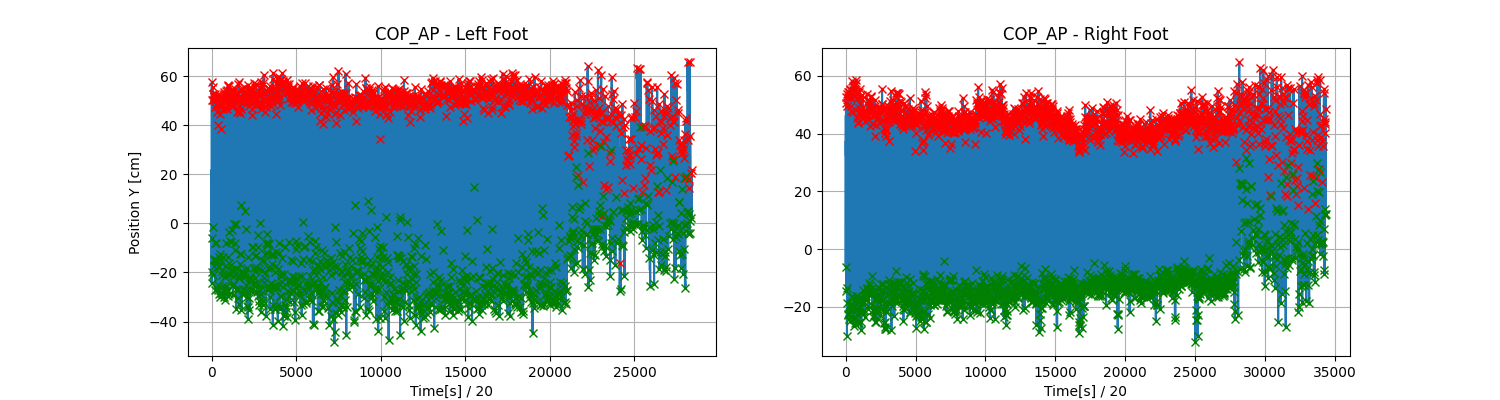

In [39]:
plt.figure(figsize=(15,4))

side = 'left'
plt.subplot(1,2,1)
plt.title('COP_AP - Left Foot')
plt.plot(xl)
plt.plot(peaks[side]['positive'], xl[peaks[side]['positive']], "x", color='red')
plt.plot(peaks[side]['negative'], xl[peaks[side]['negative']], "x", color='green')
plt.grid(True)
plt.axis('tight')
plt.ylabel('Position Y [cm]')
plt.xlabel('Time[s] / 20')

side = 'right'
plt.subplot(1,2,2)
plt.title('COP_AP - Right Foot')
plt.plot(xr)
plt.plot(peaks[side]['positive'], xr[peaks[side]['positive']], "x", color='red')
plt.plot(peaks[side]['negative'], xr[peaks[side]['negative']], "x", color='green')
plt.grid(True)
plt.axis('tight')
plt.xlabel('Time[s] / 20')

plt.show()


# Calculations

In [40]:
def gait_timings(positive, negative): 
    pairs = {
        'step': [],
        'swing': [],
        'stride': []
    }
    
    timings = {
        'step': [],
        'swing': [],
        'stride': []
    }
    
    for n in negative:
        for p in positive:
            if n < p:
                time = abs(p - n)
                pairs['step'].append((n, p))
                timings['step'].append(time*0.05)
                break
            
    for p in positive:
        for n in negative:
            if n > p:
                time = abs(n - p)
                pairs['swing'].append((p, n))
                timings['swing'].append(time*0.05)
                break
            
    for i in range(len(negative) - 1):
        time = abs(negative[i] - negative[i+1])
        pairs['stride'].append((negative[i], negative[i + 1]))
        timings['stride'].append(time*0.05)        
            
    return timings, pairs
            

def find_cop_velocity(data, time, peaks):
    velocity_array = []
    
    for i in range(len(time)):
        p, n = peaks[i]
        velocity_array.append((data[n] - data[p]) / time[i])
        
    return velocity_array

        

In [41]:
side = 'left'
l_timings, l_pairs = gait_timings(peaks[side]['positive'], peaks[side]['negative'])
l_velocity = find_cop_velocity(xl, l_timings['step'], l_pairs['step'])

side = 'right'
r_timings, r_pairs = gait_timings(peaks[side]['positive'], peaks[side]['negative'])
r_velocity = find_cop_velocity(xr, r_timings['step'], r_pairs['step'])

print('Calculations: ')
print()
print('-----------------------------------')
print('LEFT')
side = 'left'
print('Average Step Time:', '%.2f' % np.mean(l_timings['step']), '[sec]')
print('Average Swing Time:', '%.2f' % np.mean(l_timings['swing']), '[sec]')
print('Average Stride Time:', '%.2f' % np.mean(l_timings['stride']),'[sec]')
print("Step Time Variability:", '%.2f' % np.std(l_timings["step"]))
print("Stride Time Variability:", '%.2f' % np.std(l_timings["stride"]))
print('Average COP Velocity: ', '%.2f' % np.mean(l_velocity), '[mm/s]')
print('COP Variability:', '%.2f' % np.std(filt_cop[side]))
print()
print('-----------------------------------')
print('RIGHT')
side = 'right'
print('Average Step Time:', '%.2f' % np.mean(r_timings['step']), '[sec]')
print('Average Swing Time:', '%.2f' % np.mean(r_timings['swing']), '[sec]')
print('Average Stride Time:', '%.2f' % np.mean(r_timings['stride']),'[sec]')
print("Step Time Variability:", '%.2f' % np.std(r_timings["step"]))
print("Stride Time Variability:", '%.2f' % np.std(r_timings["stride"]))
print('Average COP Velocity: ', '%.2f' % np.mean(r_velocity), '[mm/s]')
print('COP Variability:', '%.2f' % np.std(filt_cop[side]))


Calculations: 

-----------------------------------
LEFT
Average Step Time: 0.93 [sec]
Average Swing Time: 0.62 [sec]
Average Stride Time: 1.44 [sec]
Step Time Variability: 0.50
Stride Time Variability: 0.63
Average COP Velocity:  91.74 [mm/s]
COP Variability: 76.93

-----------------------------------
RIGHT
Average Step Time: 0.92 [sec]
Average Swing Time: 0.40 [sec]
Average Stride Time: 1.26 [sec]
Step Time Variability: 0.31
Stride Time Variability: 0.32
Average COP Velocity:  66.94 [mm/s]
COP Variability: 55.90


In [11]:
def calculate_gait_velocity(timings, pairs, acc_data=[]):
    gait_velocities  = []
    for i in range(len(pairs['stride'])):
        start_idx, end_idx = pairs['stride'][i]
        acc_window = acc_data[start_idx:end_idx]  # Extract acceleration data within the window
        
        time_steps = timings['stride'][i] / len(acc_window)  # Calculate time step

        # Numerical integration using trapezoidal rule
        integrated_velocity = np.trapz(acc_window, dx=0.05)

        gait_velocities.append(integrated_velocity)
        
    return gait_velocities 

## Coeficient of Variation

In [12]:
s = acc['left'][mask['left']].reset_index().iloc[:,1]

v = calculate_gait_velocity(l_timings, l_pairs, s)

print('Avg Velocity: ', np.mean(v))
print('Gait Speed CoV: ', np.std(v))


Avg Velocity:  1.7013712494603184
Gait Speed CoV:  1.8713147329750441


In [22]:
A = v
cv =  lambda x: np.std(x) / np.mean(x)
var = np.apply_along_axis(cv, axis=0, arr=A)
idmax = np.argmax(var)

In [33]:
var

array(1.09988619)

# Velocity Calculations from Acceleration

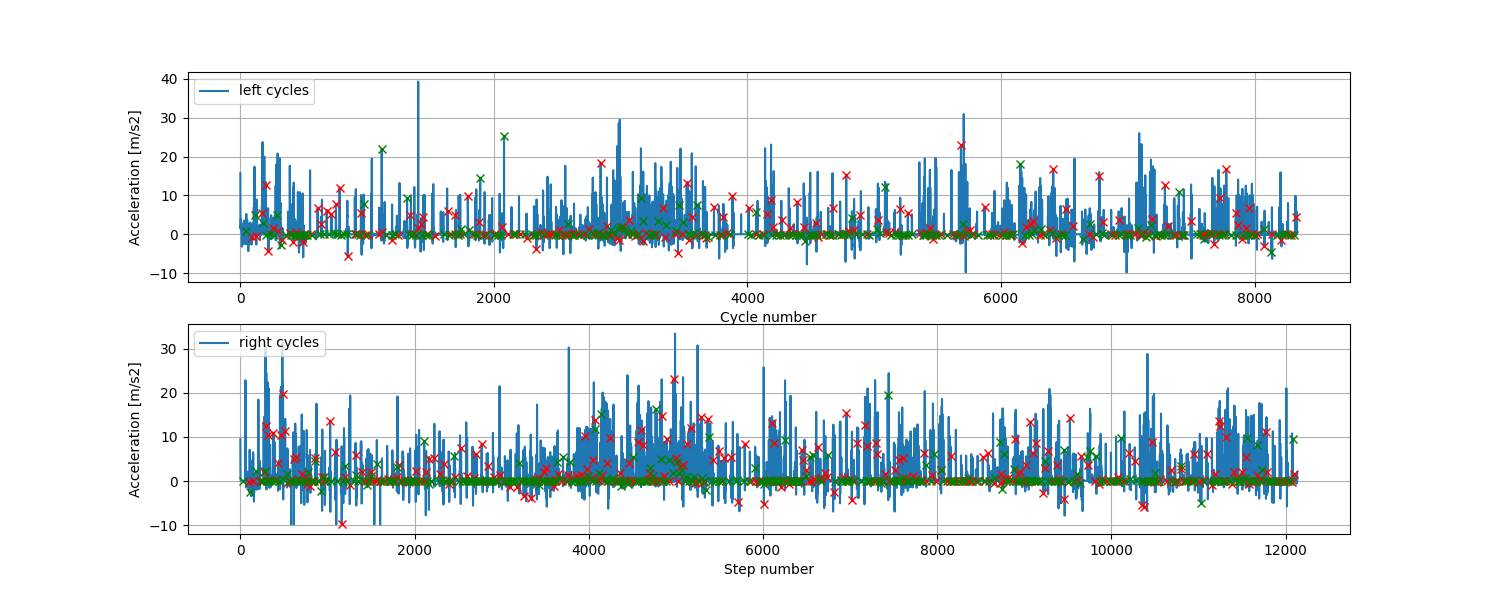

In [14]:
l_acc_masked = acc['left'][mask['left']].reset_index().iloc[:,1]
r_acc_masked = acc['right'][mask['right']].reset_index().iloc[:,1]

plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(l_acc_masked, label='left cycles')
plt.plot(peaks['left']['positive'], l_acc_masked[peaks['left']['positive']], "x", color='red')
plt.plot(peaks['left']['negative'], l_acc_masked[peaks['left']['negative']], "x", color='green')
plt.ylabel('Acceleration [m/s2]')
plt.xlabel('Cycle number')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.subplot(2,1,2)
plt.plot(r_acc_masked, label='right cycles')
plt.plot(peaks['right']['positive'], r_acc_masked[peaks['right']['positive']], "x", color='red')
plt.plot(peaks['right']['negative'], r_acc_masked[peaks['right']['negative']], "x", color='green')
plt.ylabel('Acceleration [m/s2]')
plt.xlabel('Step number')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')


# Sensor Details

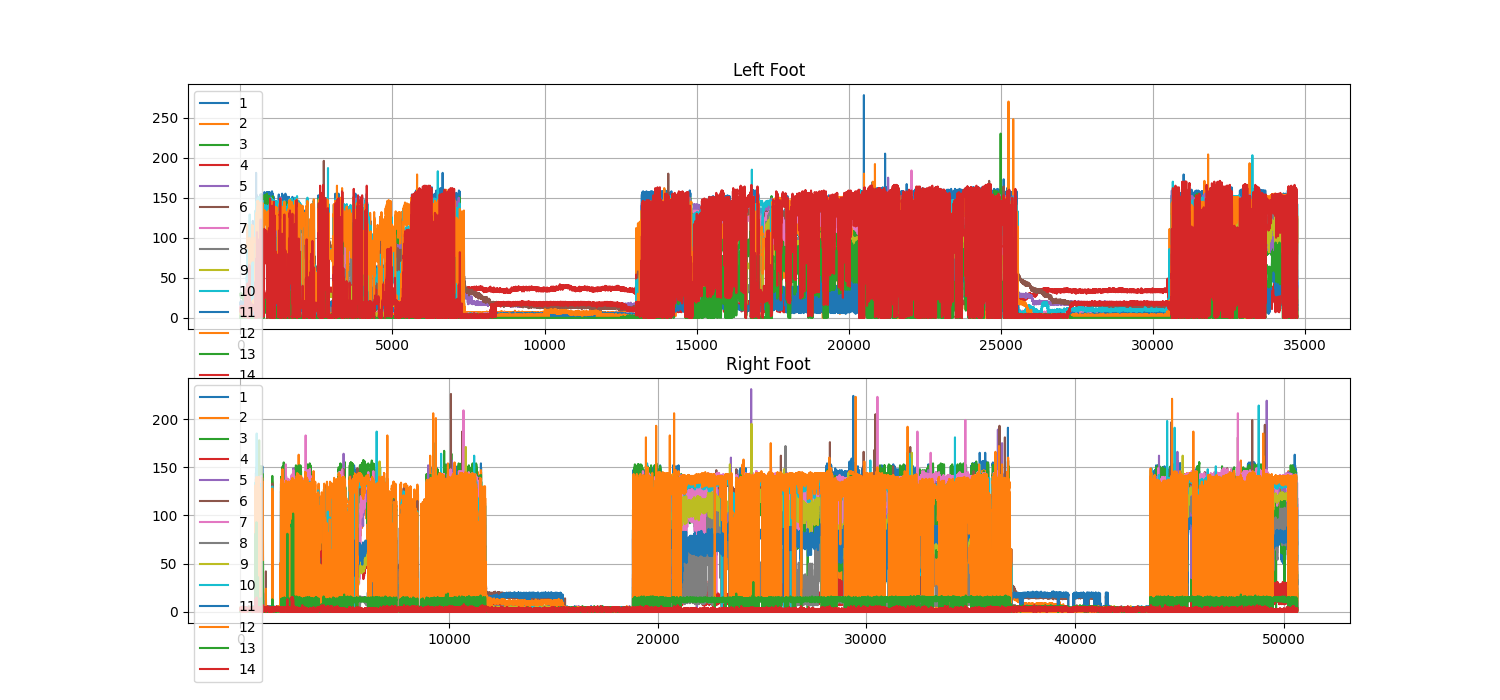

In [15]:
d = raw_left[['raw_1', 'raw_2', 'raw_3', 'raw_4', 'raw_5', 'raw_6',
                'raw_7', 'raw_8', 'raw_9', 'raw_10', 'raw_11', 'raw_12',
                'raw_13', 'raw_14']]

plt.figure(figsize=(15,7))
plt.subplot(2,1,1)
for col in d.columns:
    plt.plot(d[col], label=col.split('_')[1])
    
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.title('Left Foot')

d = raw_right[['raw_1', 'raw_2', 'raw_3', 'raw_4', 'raw_5', 'raw_6',
                'raw_7', 'raw_8', 'raw_9', 'raw_10', 'raw_11', 'raw_12',
                'raw_13', 'raw_14']]

plt.subplot(2,1,2)
for col in d.columns:
    plt.plot(d[col], label=col.split('_')[1])
    
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.title('Right Foot')

plt.show()
